In [46]:
from IPython.display import Image
from typing import List, Union, Dict, Any

from dotenv import load_dotenv
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.outputs import LLMResult
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import Tool, render_text_description, tool
from langchain_openai import ChatOpenAI

# https://python.langchain.com/docs/concepts/tools/

# https://python.langchain.com/docs/integrations/tools/

# https://python.langchain.com/api_reference/core/tools/langchain_core.tools.render.render_text_description.html

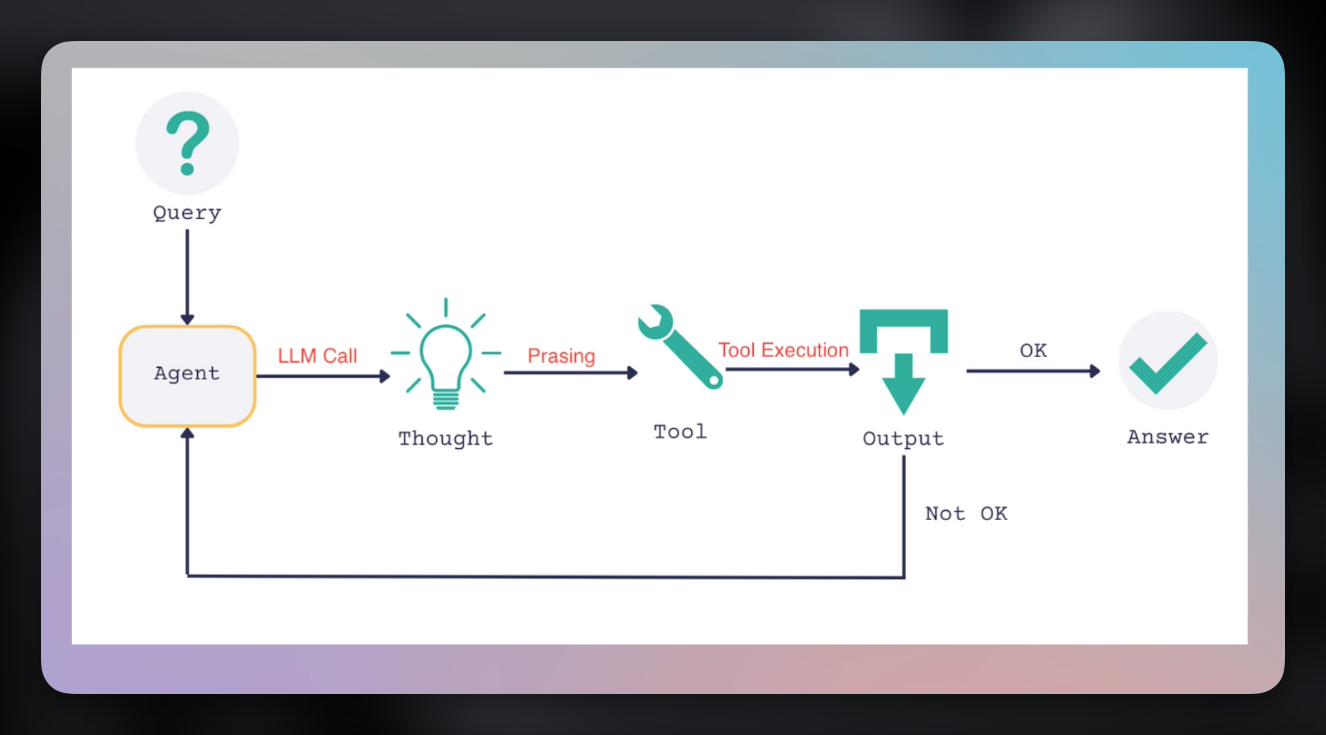

In [5]:
Image("Images/2025-09-22/CleanShot 2025-09-23 at 02.53.39.png")

In [9]:
@tool
def get_text_length(text: str) -> int:
    """Returns the length of a text by characters"""
    print(f"get_text_length enter with {text=}")
    text = text.strip("'\n").strip(
        '"'
    )  # stripping away non alphabetic characters just in case

    return len(text)

In [10]:
print(get_text_length.invoke(input={"text": "Dog"}))

get_text_length enter with text='Dog'
3


In [21]:
# https://smith.langchain.com/hub/hwchase17/react

template = """
    Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought:
    """

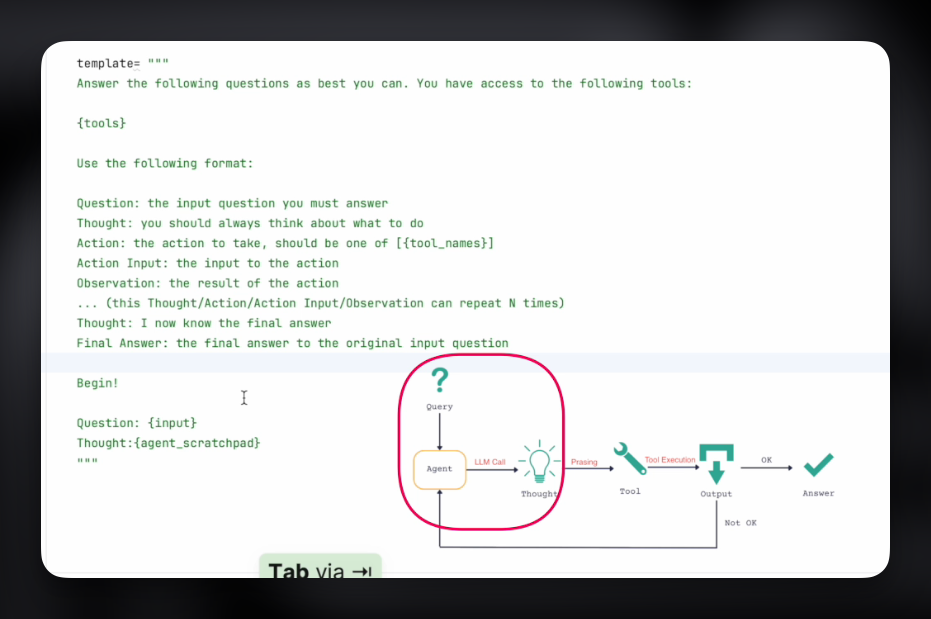

In [22]:
'''
In the React algorithm,this prompt is going to be sent to the LLM,and this is going to generate the thought of the LLM,which is going to help us select the correct tool.
'''

Image("Images/2025-09-22/CleanShot 2025-09-23 at 03.17.20.png")

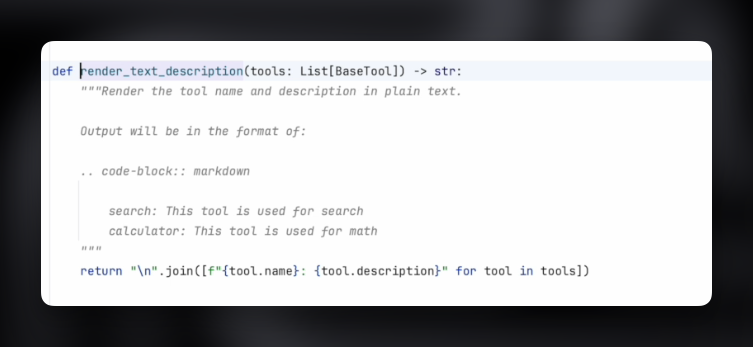

In [23]:
Image("Images/2025-09-22/CleanShot 2025-09-23 at 03.25.15.png")

In [24]:
tools = [get_text_length]

prompt = PromptTemplate.from_template(template=template).partial(
        tools=render_text_description(tools),
        tool_names=", ".join([t.name for t in tools]),
    )

In [25]:

'''
And now we're going to plug in the stop argument.And here the values are going to be \nObservation.

So this will tell the LLM to stop generating words and to finish working once it's outputted the back \nObservation token.
'''
llm = ChatOpenAI(
        temperature=0,
        stop=["\nObservation", "Observation"]
    )

In [26]:
'''
The pipe operator takes the output of its left side and plugs it in into the input of its right side.

So here it's going to run the prompt step, which is going to output prompt value.

And it's going to input it into the LM because LMS receives a prompt value.
'''

agent= prompt | llm

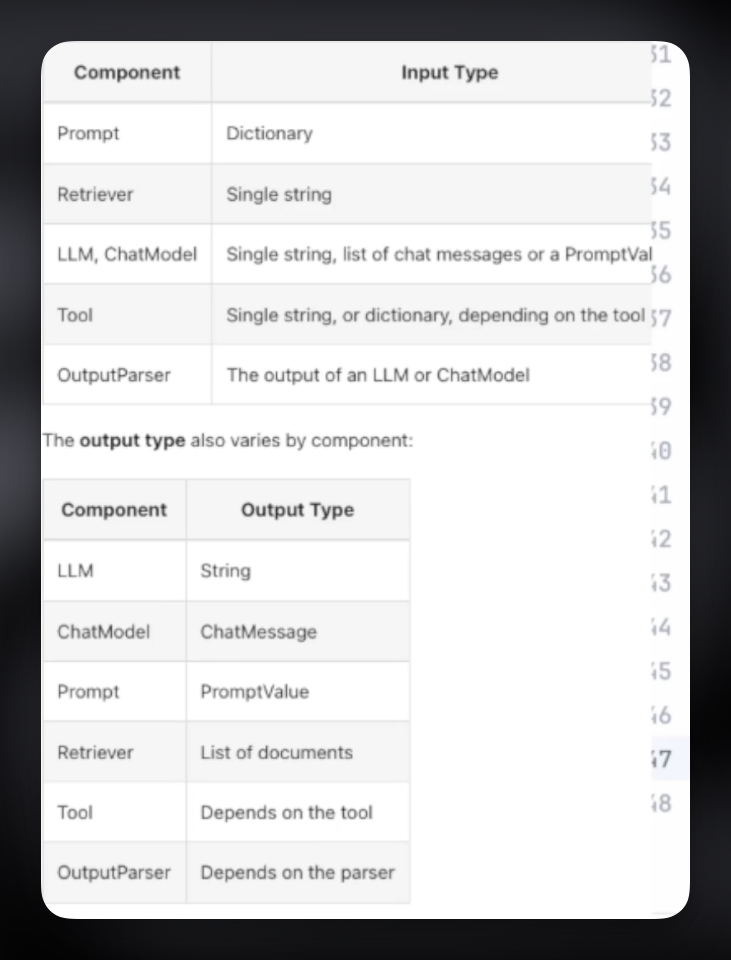

In [27]:
Image("Images/2025-09-22/CleanShot 2025-09-23 at 03.39.19.png")

In [28]:
'''
So we're going to input our prompt with a dictionary that's going to contain the key of input.

And its value is going to hold eventually the question that we're going to be asking our agent.

So because we want everything to be dynamic, we won't be passing right here.

The prompt that we're going to send to the agent, we're going to pass it when we invoke all of this chain. And when we invoke the chain, we need to supply it with a dictionary of the keywords that we're going to replace the placeholders.

So because of that, instead of putting here the input, we're going to write a lambda function that is receiving a dictionary and is accessing the input key of that dictionary.
'''

agent= {"input": lambda x: x["input"]}|prompt | llm

In [29]:
res = agent.invoke({"input": "What is the text length of 'DOG' in characters?'"})
print(res)

content="I should use the get_text_length function to determine the length of the text 'DOG'.\n    Action: get_text_length\n    Action Input: 'DOG'\n    " additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 174, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CIj9Dtj6xbQqvcHtylKjAvCtzZy3r', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--7dab6d27-971a-4e6b-8112-7c30c8c05d09-0' usage_metadata={'input_tokens': 174, 'output_tokens': 34, 'total_tokens': 208, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [30]:
'''
And this covers in the react algorithm, the query part which we plug into the agent.

And how does the agent comprise an elaborate prompt which is sent to the LLM.

Then the LLM functions as a reasoning agent to select the correct tool, and returns us a response containing all the information about which tool is selected and need to be run.

And now we'll need to go and parse this output that we just saw.And now we're going to see how we can take this response.

And we can actually invoke this function.

So to do that we'll need to parse this text and to retrieve from it the action and action input and translate it to it, to the function that we need to call and to the arguments that we need to supply it.

Langchain is going to do all the work for us because they already implemented the output parser, which take the output of the LLM in the react agent and simply parse it into the components that we need.
'''

agent= {"input": lambda x: x["input"]}|prompt | llm | ReActSingleInputOutputParser()

res = agent.invoke({"input": "What is the text length of 'DOG' in characters?'"})
print(res)

tool='get_text_length' tool_input="'DOG'\n" log="I should use the get_text_length function to determine the length of the text 'DOG'.\n    Action: get_text_length\n    Action Input: 'DOG'\n    "


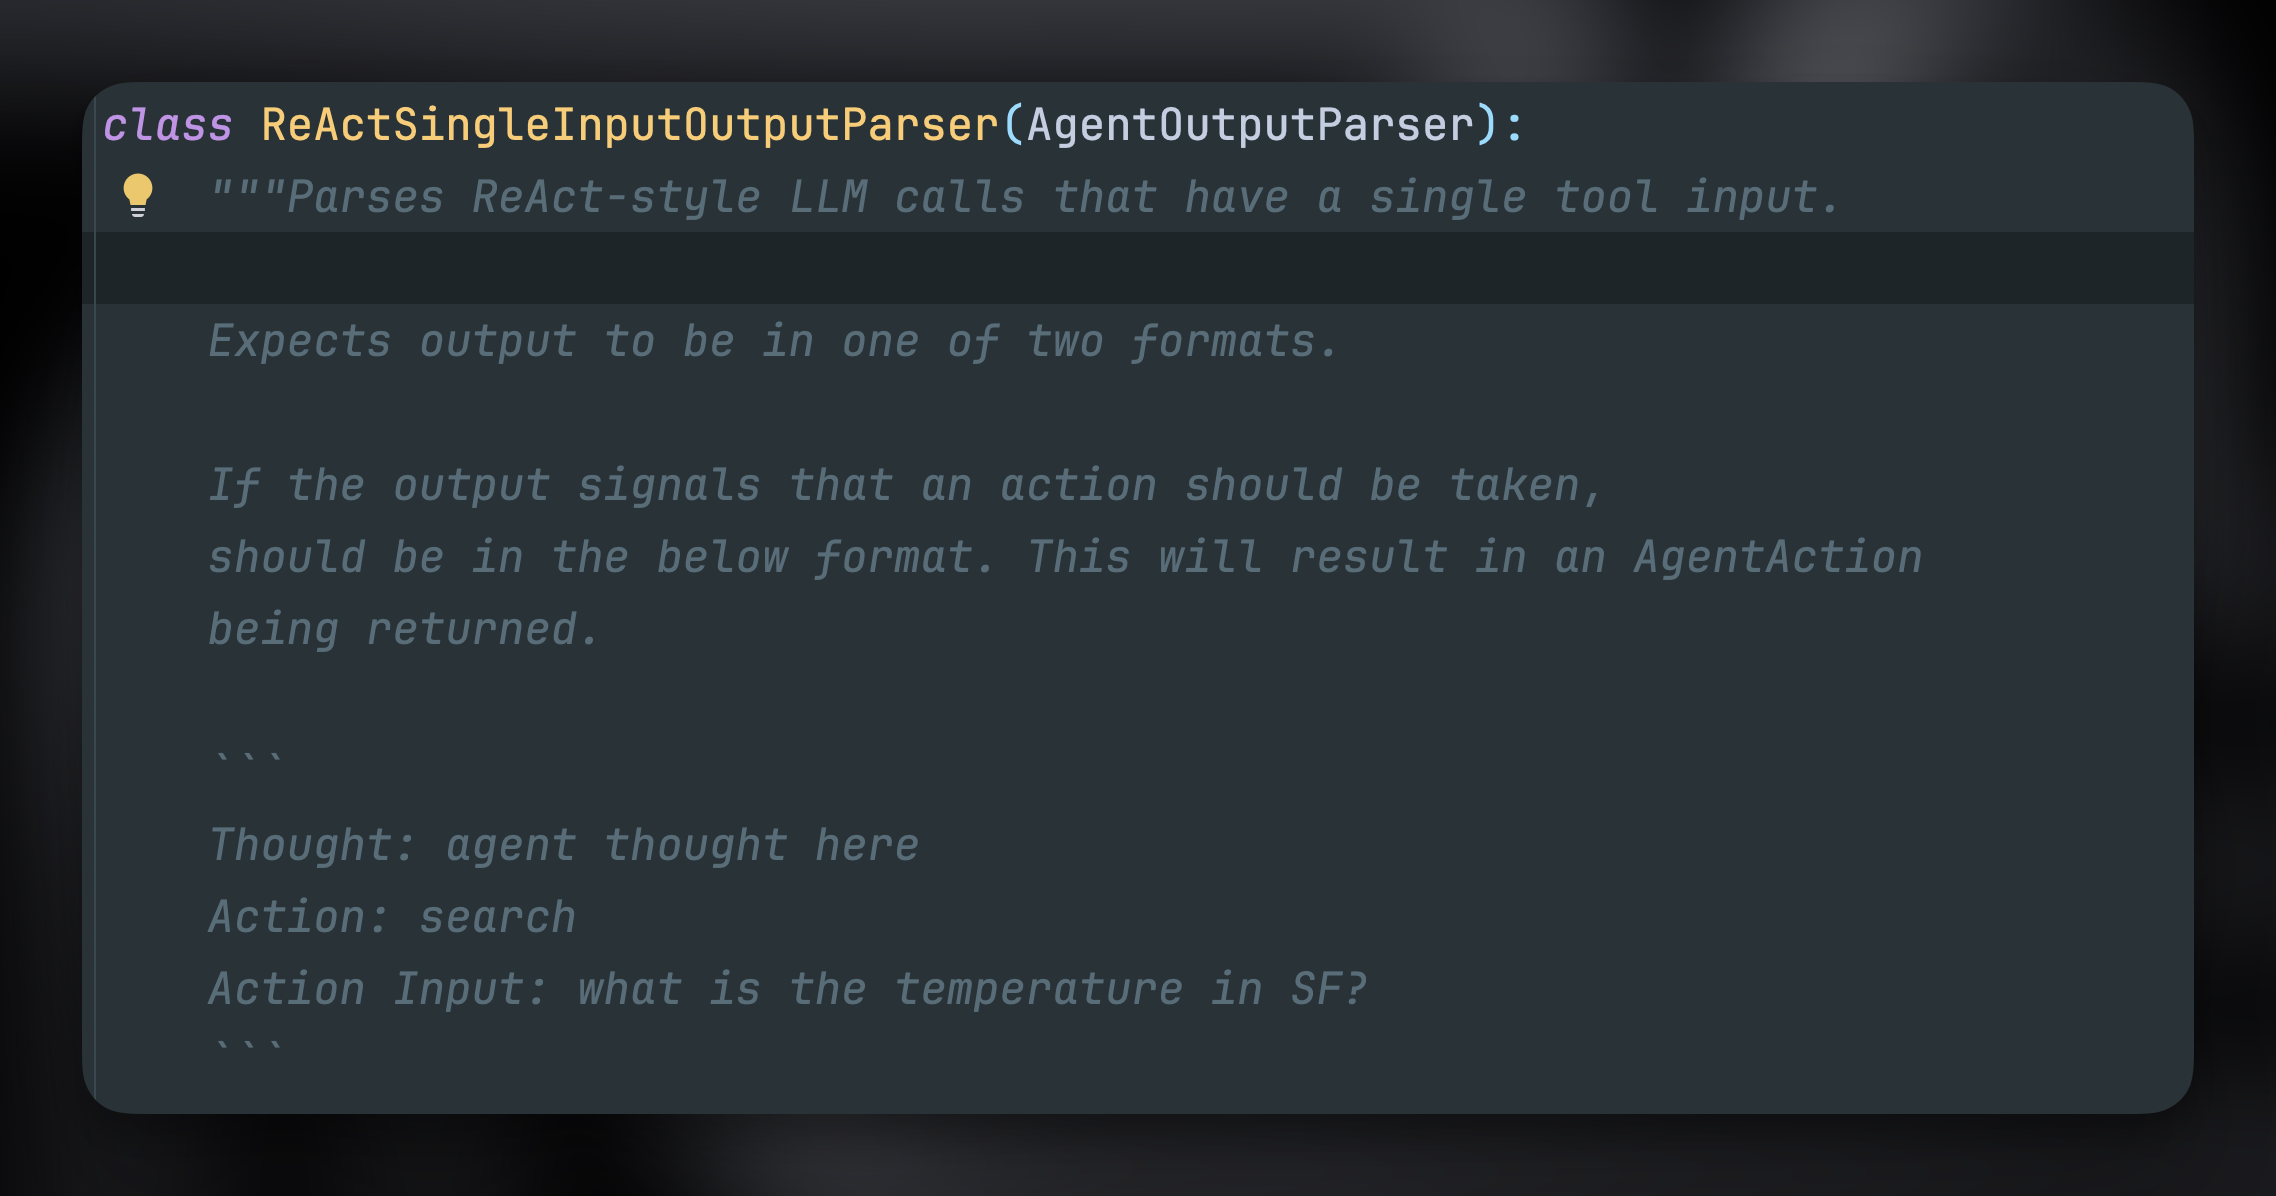

In [33]:
'''
So right now we finished with the parsing part.

And now we want to go to the tool execution.

So we have now all the information about which tool we want to execute.

So now we just need to execute this tool.
'''

Image("Images/2025-09-22/CleanShot 2025-09-23 at 04.01.21@2x.png")

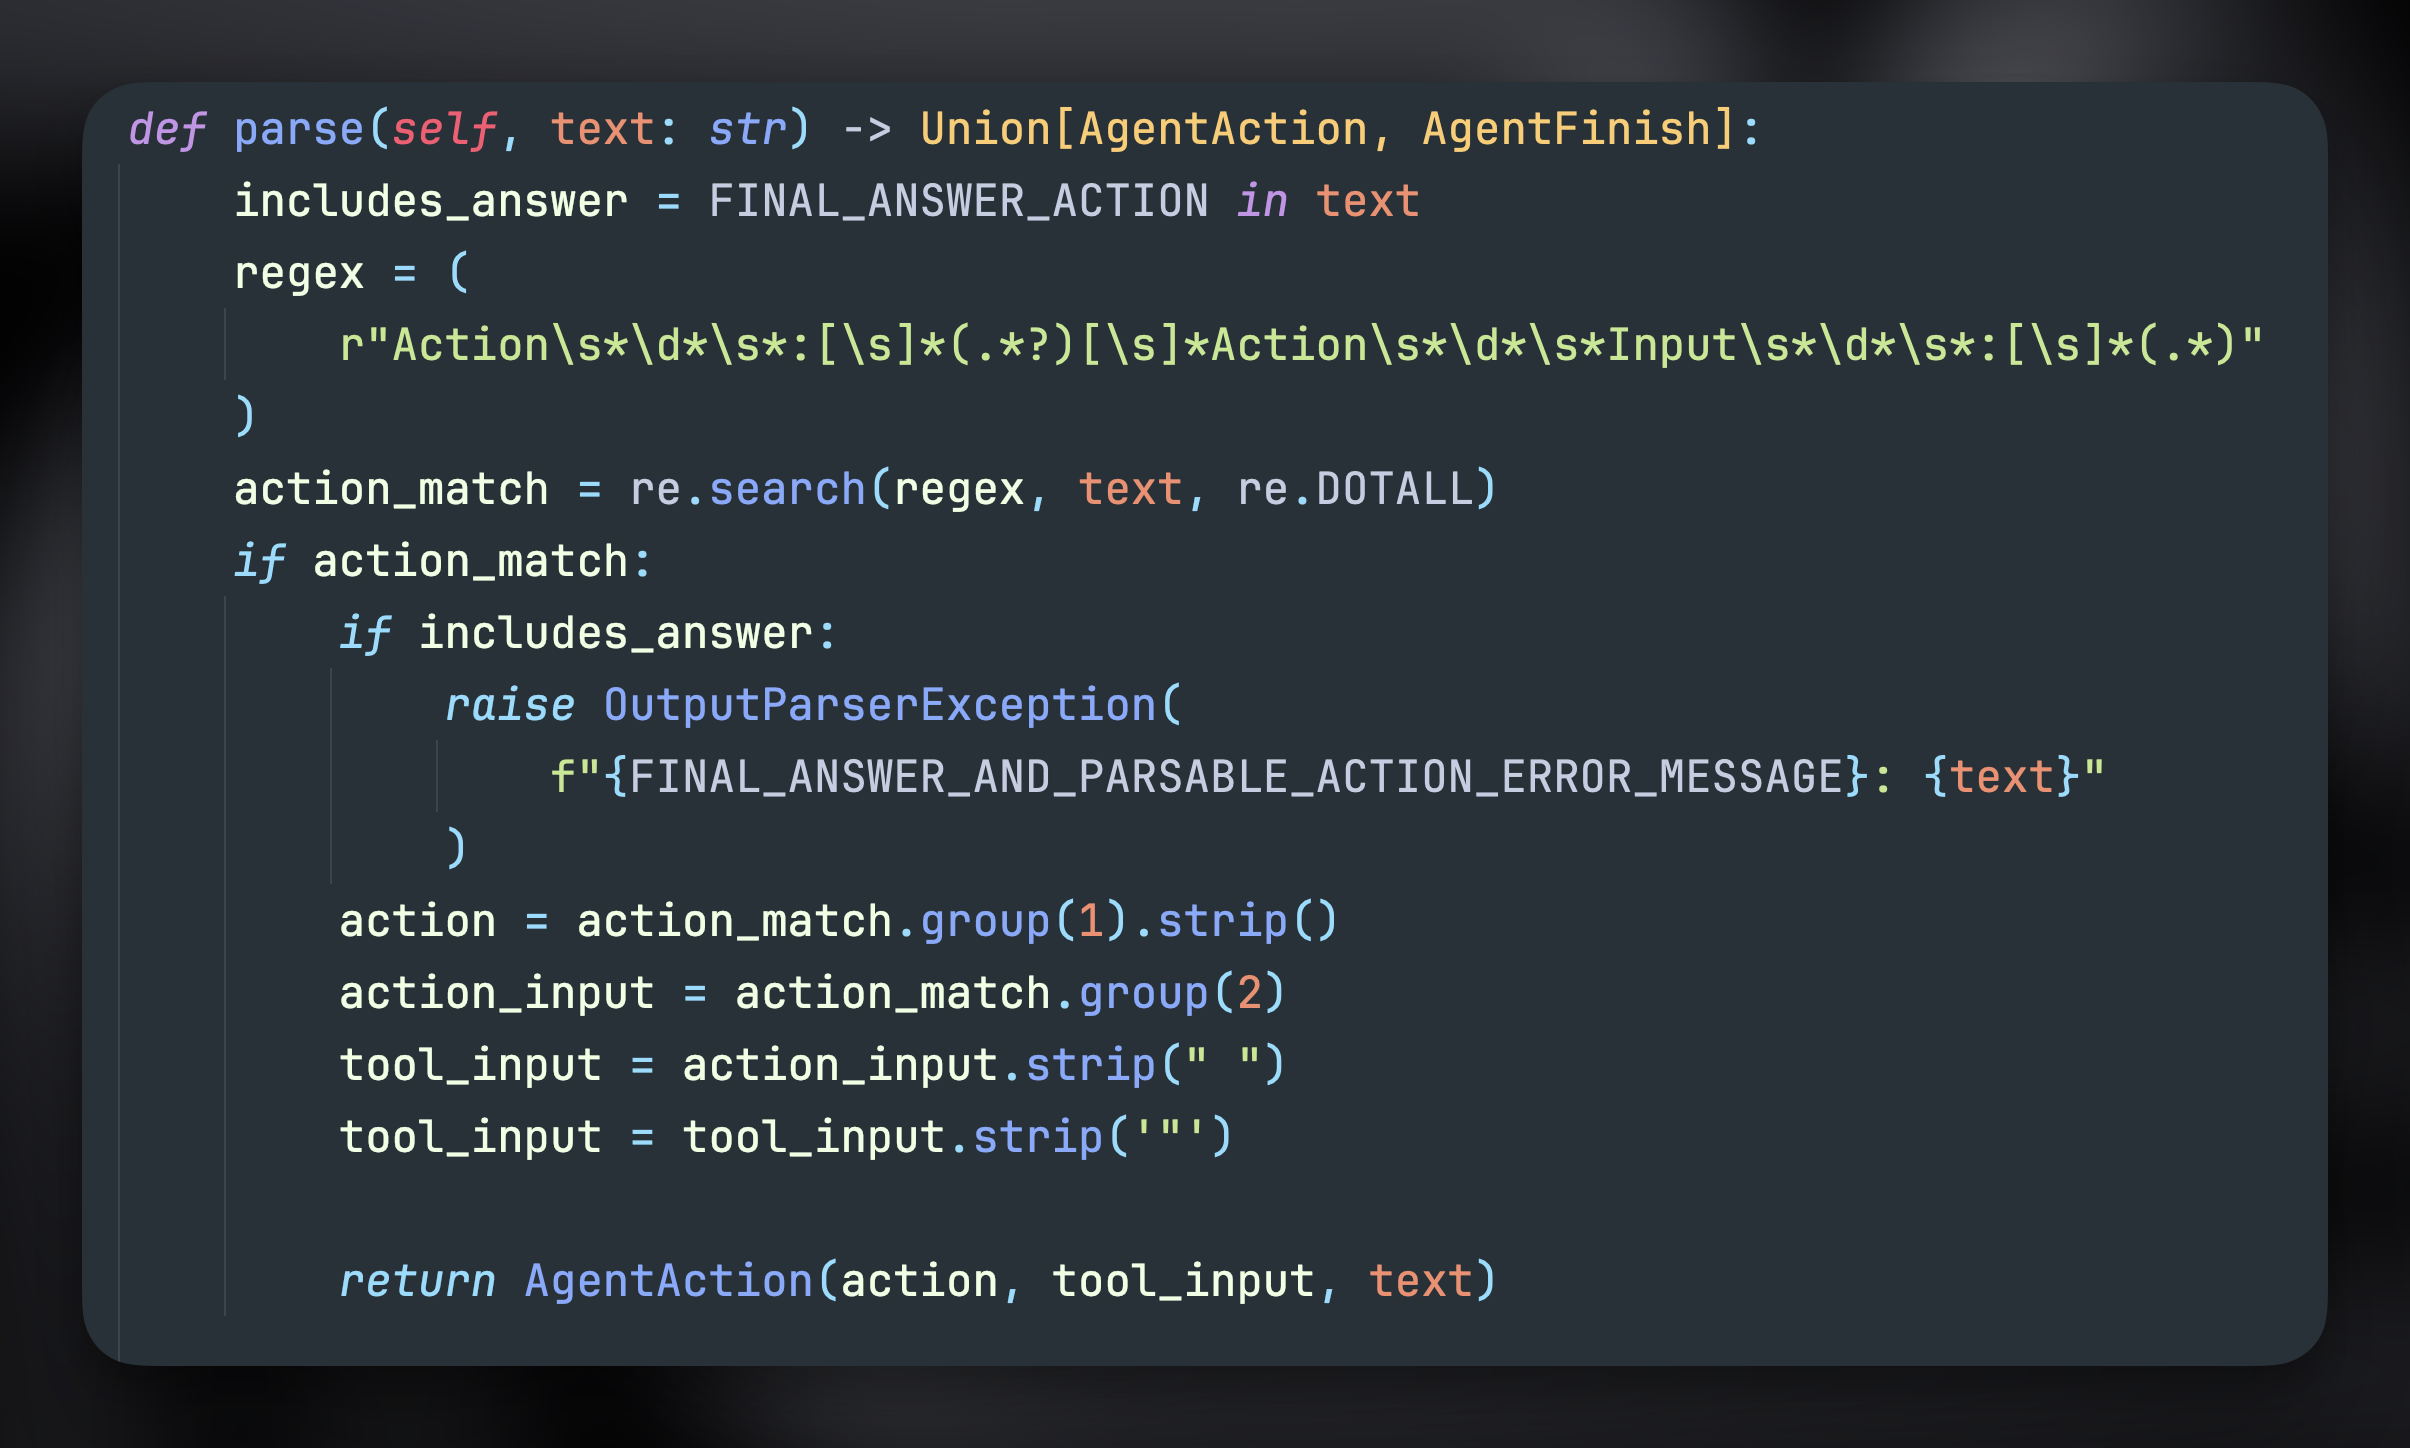

In [35]:
'''
So right now we finished with the parsing part.

And now we want to go to the tool execution.

So we have now all the information about which tool we want to execute.

So now we just need to execute this tool.
'''

Image("Images/2025-09-22/CleanShot 2025-09-23 at 04.02.19@2x.png")

In [32]:
agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
{"input": "What is the length of 'DOG' in characters?'"})

print(agent_step)

tool='get_text_length' tool_input="'DOG'\n" log="I should use the get_text_length function to determine the length of the text 'DOG'.\n    Action: get_text_length\n    Action Input: 'DOG'\n    "


In [38]:
def find_tool_by_name(tools: List[Tool], tool_name: str) -> Tool:
    for tool in tools:
        if tool.name == tool_name:
            return tool
    raise ValueError(f"Tool wtih name {tool_name} not found")


if isinstance(agent_step,AgentAction) :
    tool_name = agent_step.tool
    print(f"{tool_name=}")
    tool_to_use = find_tool_by_name(tools, tool_name)
    print(f"{tool_to_use=}")
    tool_input = agent_step.tool_input
    print(f"{tool_input=}")
    observation = tool_to_use.func(str(tool_input))
    print(f"{observation=}")


tool_name='get_text_length'
tool_to_use=StructuredTool(name='get_text_length', description='Returns the length of a text by characters', args_schema=<class 'langchain_core.utils.pydantic.get_text_length'>, func=<function get_text_length at 0x10b5caac0>)
tool_input="'DOG'\n"
get_text_length enter with text="'DOG'\n"
observation=3


In [39]:
template = """
    Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought: {agent_scratchpad}
    """

In [40]:
intermediate_steps = []
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["agent_scratchpad"]),
    }
    | prompt
    | llm
    | ReActSingleInputOutputParser()
)

In [41]:
agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
            {
                "input": "What is the length of the word: DOG",
                "agent_scratchpad": intermediate_steps,
            }
        )
print(agent_step)

tool='get_text_length' tool_input='DOG"\n' log='I should use the get_text_length function to find the length of the word "DOG".\n    Action: get_text_length\n    Action Input: "DOG"\n    '


In [42]:
if isinstance(agent_step,AgentAction) :
    tool_name = agent_step.tool
    print(f"{tool_name=}")
    tool_to_use = find_tool_by_name(tools, tool_name)
    print(f"{tool_to_use=}")
    tool_input = agent_step.tool_input
    print(f"{tool_input=}")
    observation = tool_to_use.func(str(tool_input))
    print(f"{observation=}")
    intermediate_steps.append((agent_step, str(observation)))

tool_name='get_text_length'
tool_to_use=StructuredTool(name='get_text_length', description='Returns the length of a text by characters', args_schema=<class 'langchain_core.utils.pydantic.get_text_length'>, func=<function get_text_length at 0x10b5caac0>)
tool_input='DOG"\n'
get_text_length enter with text='DOG"\n'
observation=3


In [44]:
if isinstance(agent_step, AgentFinish):
    print(agent_step.return_values)

In [47]:
# https://python.langchain.com/docs/modules/callbacks/

class AgentCallbackHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        """Run when LLM starts running."""
        print(f"***Prompt to LLM was:***\n{prompts[0]}")
        print("*********")

    def on_llm_end(self, response: LLMResult, **kwargs: Any) -> Any:
        """Run when LLM ends running."""
        print(f"***LLM Response:***\n{response.generations[0][0].text}")
        print("*********")

In [50]:
llm = ChatOpenAI(
        temperature=0,
        stop=["\nObservation", "Observation"],
        callbacks=[AgentCallbackHandler()],
    )
intermediate_steps = []
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["agent_scratchpad"]),
    }
    | prompt
    | llm
    | ReActSingleInputOutputParser()
)

agent_step = ""
while not isinstance(agent_step, AgentFinish):
    agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
        {
            "input": "What is the length of the word: DOG",
            "agent_scratchpad": intermediate_steps,
        }
    )
    print(agent_step)

    if isinstance(agent_step, AgentAction):
        tool_name = agent_step.tool
        tool_to_use = find_tool_by_name(tools, tool_name)
        tool_input = agent_step.tool_input

        observation = tool_to_use.func(str(tool_input))
        print(f"{observation=}")
        intermediate_steps.append((agent_step, str(observation)))

if isinstance(agent_step, AgentFinish):
    print(agent_step.return_values)

***Prompt to LLM was:***
Human: 
    Answer the following questions as best you can. You have access to the following tools:

    get_text_length(text: str) -> int - Returns the length of a text by characters

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [get_text_length]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: What is the length of the word: DOG
    Thought:
    
*********
***LLM Response:***
I should use the get_text_length function to find the length of the word "DOG".
    Action: get_text_length
    Action Input: "DOG"
    
*********
tool='get_text_length' tool_input='DOG"\n' log='I should use the g

KeyboardInterrupt: 